# Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Functions

In [3]:
# functions
def get_names(df, start, stop):
    player_list = []
    drop_list = df.iloc[:, start:stop:3].columns.tolist()
    name_df = df.drop(drop_list, axis=1, inplace=False)
    name_df = name_df.iloc[:, start:stop-len(drop_list)]
    for i in range(len(name_df)):
        players = name_df.iloc[i].tolist()
        players_sorted = [players[j] for j in range(0, len(players), 2)]
        players_sorted.sort(key=lambda x: players[players.index(x) + 1])
        player_list.append(players_sorted)
    return player_list


def list_stacker(pitchers, players):
    for i in range(len(pitchers)):
        players[i].insert(0, pitchers[i])
    return players


def get_game_data(paths):
    all_data = []
    for i in range(len(paths)):
        df = pd.read_csv(paths[i], header=None)
        visiting_players = get_names(df, 105, 132)
        home_players = get_names(df, 132, 159)
        home_pitchers = df.iloc[:, 104].tolist()
        visiting_pitchers = df.iloc[:, 102].tolist()
        visiting_players = list_stacker(visiting_pitchers, visiting_players)
        home_players = list_stacker(home_pitchers, home_players)
        visiting_scores = df.iloc[:, 9].tolist()
        home_scores = df.iloc[:, 10].tolist()
        all_data.extend(list(zip(visiting_players, home_players, visiting_scores, home_scores)))
    return all_data


def get_player_data(paths):
    le = LabelEncoder()
    player_dfs = []
    for path in paths:
        df = pd.read_csv(path)
        df['Team'] = le.fit_transform(df['Team'])
        if 'Pos' in df.columns:
            df['Pos'] = le.fit_transform(df['Pos'])
        if 'Batters' not in path:
            df['ExtraCol1'] = 0
            df['ExtraCol2'] = 0
            df['ExtraCol3'] = 0
        df.columns = ['Player'] + list(range(len(df.columns) - 1))
        df['Player'] = df['Player'].str.lower()
        player_dfs.append(df)
    combined_player = pd.concat(player_dfs)
    combined_player = combined_player.groupby('Player', as_index=False).mean()
    final_player = combined_player.set_index('Player').T.to_dict('list')
    return final_player


def get_example(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    stacked_vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    if game[2] > game[3]:
        label = 0
    else:
        label = 1
    return stacked_vector, label


def generate_vectors_and_labels(game_data, player_data):
    vectors, labels = [], []
    for game in tqdm(game_data):
        try:
            vector, label = get_example(game, player_data)
            if np.isnan(vector).any() or np.isnan(label):
                continue
            vectors.append(vector)
            labels.append(label)
        except:
            continue
    return pd.DataFrame(np.array(vectors)), pd.DataFrame(np.array(labels))


def generate_vector(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    return np.array(vector)


# NN
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


def train(model,
          train_loader,
          test_loader,
          optimizer,
          criterion,
          best_model_path='./best_model.pth',
          patience=10,
          epochs=100):
    for epoch in range(epochs):  # number of epochs
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return model, all_preds, all_labels


def eval(model, games):
    total = len(games)
    for i, game in enumerate(games):
        try:
            
            if np.isnan(vector).any():
            print('NAN in data')
    except:
        print('Some players were not found')

# Load data

In [4]:
player_path = './player_data/'
paths = [path.replace('\\', '/') for path in glob(player_path + '*.csv')]
for path in paths:
    df = pd.read_csv(path)
    view_data(df)

There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset


In [5]:
# load data
test_year = '2021'
game_path = './game_data/'
player_path = './player_data/'

game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if test_year not in path]
game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if test_year in path]

player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if test_year not in path]
player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if test_year in path]

train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

train_player_data = get_player_data(player_csvs_train)
test_player_data = get_player_data(player_csvs_test)

X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

  0%|          | 0/27624 [00:00<?, ?it/s]

  0%|          | 0/2429 [00:00<?, ?it/s]

# Train NN

In [ ]:
model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.2)

train_dataset = vector_dataset(X_train, y_train)
test_dataset = vector_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

patience = 5
best_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'  # File path for saving the best model

model, all_preds, all_labels = train(model=model, train_loader=)
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Epoch 1:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6842927506095484
Validation Loss: 0.6787519774266652


Epoch 2:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6723089403227756
Validation Loss: 0.6763949990272522


Epoch 3:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6627314542469226
Validation Loss: 0.6691953177962985


Epoch 4:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.652692867580213
Validation Loss: 0.6726098890815463


Epoch 5:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6357242261108599
Validation Loss: 0.6952334727559771


Epoch 6:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6181881989303388
Validation Loss: 0.693275375025613


Epoch 7:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.5885709141430102
Validation Loss: 0.712985424058778


Epoch 8:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.5541800818945232
Validation Loss: 0.7652790567704609
Early stopping triggered
Confusion Matrix:
[[661 292]
 [426 411]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       953
           1       0.58      0.49      0.53       837

    accuracy                           0.60      1790
   macro avg       0.60      0.59      0.59      1790
weighted avg       0.60      0.60      0.59      1790



# Train SVM

In [9]:
# SVM
# Define hyperparameters for search
param_grid = param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']}


# Grid search for hyperparameters
clf = GridSearchCV(svm.SVC(), param_grid, refit=True, cv=3, verbose=3)
clf.fit(X_train, y_train)

# Predict using the best model
y_pred = clf.predict(X_test)

class_report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()

print("Classification Report:")
print(class_report)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.536 total time=  32.8s
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.536 total time=  32.1s


# Feature ranking

Fitting 3 folds for each of 10 candidates, totalling 30 fits


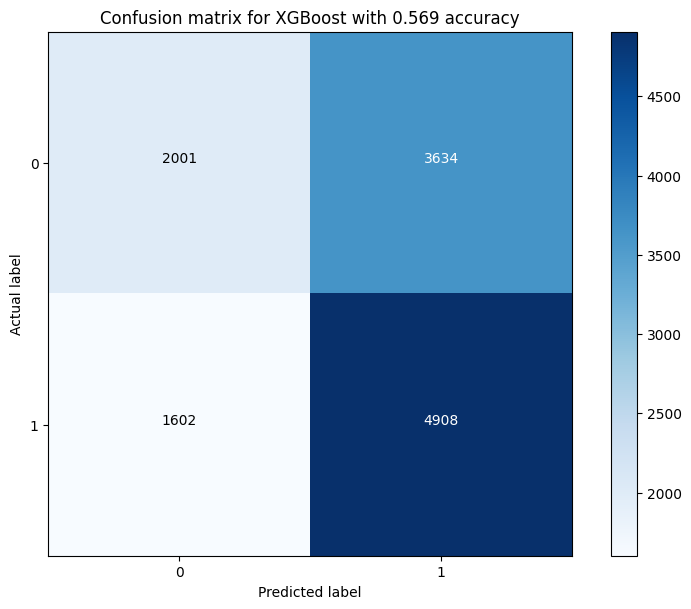

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [6]:
# forests and feature ranking
hypers = classification_hyper_param_search(X_train, y_train, 3, 10)
xb_hypers = hypers[0]['best_params']
rf_hypers = hypers[1]['best_params']
ranking = classification_ranking(X_train, y_train, rf_hypers, xb_hypers)
scoring = voting(ranking)
#plot_ranking(scoring, title='Classification example')

# Wallet

In [ ]:
"""
EXTRA
def get_player_data(paths):
    player_dfs = [pd.read_csv(path) for path in paths]
    player_dfs = [df.assign(Name=df['last_name, first_name'].apply(lambda x: ' '.join(x.split(', ')[::-1]).lower())).drop(columns=['player_id', 'last_name, first_name']) for df in player_dfs]
    combined_player = pd.concat(player_dfs).groupby('Name', as_index=False).mean()
    final_player = combined_player.set_index('Name').T.to_dict('list')
    return final_player

df.iloc[:, 102] # visiting pitchers
df.iloc[:, 104] # home pitchers
df.iloc[:, 105:132] # visiting players
df.iloc[:, 132:159] # home players
df.iloc[:, 9] # visiting score
df.iloc[:, 10] # home score
df.iloc[:, 3] # visiting team
df.iloc[:, 6] # home team
visiting_teams = df.iloc[:, 3].tolist()
home_teams = df.iloc[:, 6].tolist()
"""

"""
# instantiate the random undersampler
rus = RandomUnderSampler(random_state=42)

# instantiate SMOTE
smote = SMOTE(random_state=42)

# resample X_train and y_train using undersampling
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# resample X_train and y_train using SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print the new class distribution after undersampling
print('Resampled dataset shape after undersampling %s' % len(X_train_resampled))

# print the new class distribution after SMOTE
print('Resampled dataset shape after SMOTE %s' % len(X_train_smote))
"""